In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mzarenejad","key":"821512ae73bf6826cb7b64ae01c5e271"}'}

In [ ]:
 ! mkdir ~/.kaggle


In [ ]:
 ! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                           Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23          13237        387  1.0              
zusmani/petrolgas-prices-worldwide                                 Petrol/Gas Prices Worldwide                          10KB  2022-06-24 01:25:33           1328         76  1.0              
ruchi798/data-science-job-salaries                                 Data Science Job Salaries                             7KB  2022-06-15 08:59:12           2279         79  1.0              
devansodariya/student-performance-data       

In [ ]:
! kaggle datasets download -d andrewmvd/car-plate-detection

 95% 193M/203M [00:02<00:00, 56.8MB/s]
100% 203M/203M [00:02<00:00, 73.9MB/s]


In [ ]:
! unzip car-plate-detection

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

In [ ]:
print(extract_info_from_xml('annotations/Cars1.xml'))


{'bboxes': [{'class': 'licence', 'xmin': 134, 'ymin': 128, 'xmax': 262, 'ymax': 160}], 'filename': 'Cars1.png', 'image_size': (400, 248, 3)}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"licence": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 433/433 [00:00<00:00, 6948.84it/s]


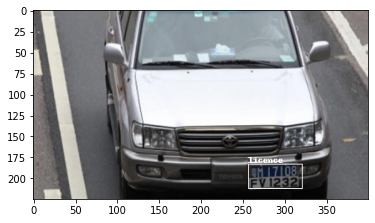

In [ ]:
random.seed(50)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [ ]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
!mv annotations labels


In [ ]:
!mkdir car-plate-detection

In [ ]:
shutil.move('images', 'car-plate-detection')

'car-plate-detection/images'

In [ ]:
shutil.move('labels', 'car-plate-detection')

'car-plate-detection/labels'

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom

img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list

results = model(img)

results.save()  # or .show(), .save(), .crop(), .pandas(), etc.

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-7-5 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Saved 1 image to runs/detect/exp


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12388, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12388 (delta 1), reused 6 (delta 0), pack-reused 12380
Receiving objects: 100% (12388/12388), 12.18 MiB | 2.06 MiB/s, done.
Resolving deltas: 100% (8544/8544), done.


In [ ]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
!cd yolov5

In [ ]:
cd /content/yolov5

/content/yolov5


In [ ]:
#Create a new file called car-plate-detection.yaml and place it in the yolov5/data folder. Then fill it with the following:
#train: /content/car-plate-detection/images/train/
#val:  /content/car-plate-detection/images/val/
#test: /content/car-plate-detection/images/test/

# number of classes
#nc: 1

# class names
#names: ["licence"]

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.scratch-med.yaml --batch 32 --epochs 50 --data /content/yolov5/data/car-plate-detection.yaml --weights yolov5s.pt --workers 24 --name yolo_plate_detection


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=/content/yolov5/data/car-plate-detection.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch-med.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_plate_detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-277-gfdc9d91 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou

In [ ]:
!python detect.py --source /content/car-plate-detection/images/test  --weights /content/yolov5/runs/train/yolo_plate_detection/weights/best.pt --conf 0.25 --name yolo_plate_detection_test

detect: weights=['/content/yolov5/runs/train/yolo_plate_detection/weights/best.pt'], source=/content/car-plate-detection/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_plate_detection_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-277-gfdc9d91 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/44 /content/car-plate-detection/images/test/Cars113.png: 480x640 2 licences, Done. (0.017s)
image 2/44 /content/car-plate-detection/images/test/Cars124.png: 448x640 3 licences, Done. (0.016s)
image 3/44 /content/car-plate-detection/images/test/Cars150.png: 480x640 1 licence

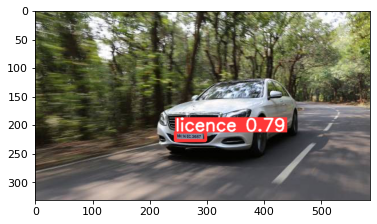

In [ ]:
detections_dir = "/content/yolov5/runs/detect/yolo_plate_detection_test"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp -av '/content/car-plate-detection' '/gdrive/MyDrive/platedetection'

'/content/car-plate-detection' -> '/gdrive/MyDrive/platedetection/car-plate-detection'
'/content/car-plate-detection/labels' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels'
'/content/car-plate-detection/labels/Cars0.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars0.xml'
'/content/car-plate-detection/labels/Cars1.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars1.xml'
'/content/car-plate-detection/labels/Cars10.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars10.xml'
'/content/car-plate-detection/labels/Cars100.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars100.xml'
'/content/car-plate-detection/labels/Cars101.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars101.xml'
'/content/car-plate-detection/labels/Cars102.xml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/labels/Cars102.xml'
'/content/car-plate-detection/labels/Cars103.xml' -> '/gdrive/MyDrive/pl

In [ ]:
!cp -av '/content/yolov5/runs' '/gdrive/MyDrive/platedetection/car-plate-detection'

'/content/yolov5/runs' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs'
'/content/yolov5/runs/train' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train'
'/content/yolov5/runs/train/yolo_plate_detection' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train/yolo_plate_detection'
'/content/yolov5/runs/train/yolo_plate_detection/weights' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train/yolo_plate_detection/weights'
'/content/yolov5/runs/train/yolo_plate_detection/weights/last.pt' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train/yolo_plate_detection/weights/last.pt'
'/content/yolov5/runs/train/yolo_plate_detection/weights/best.pt' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train/yolo_plate_detection/weights/best.pt'
'/content/yolov5/runs/train/yolo_plate_detection/hyp.yaml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/runs/train/yolo_plate_detection/hyp.yaml'
'/content/yolov5/runs/train/yolo

In [ ]:
!cp -av '/content/yolov5/data/car-plate-detection.yaml' '/gdrive/MyDrive/platedetection/car-plate-detection'


'/content/yolov5/data/car-plate-detection.yaml' -> '/gdrive/MyDrive/platedetection/car-plate-detection/car-plate-detection.yaml'
